In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#liest die Datensätze ein
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y_train = train.SalePrice
all_data = pd.concat([train, test])
all_data.drop('Id', inplace=True, axis=1)
all_data.drop('SalePrice', inplace=True, axis=1)

FileNotFoundError: File b'train.csv' does not exist

In [ ]:
col = all_data.dtypes[all_data.dtypes == "object"].index
nol = all_data.dtypes[all_data.dtypes != "object"].index
all_data[col] = all_data[col].fillna("FillNaN")
all_data = pd.get_dummies(all_data, columns=col)
all_data[nol] = all_data[nol].fillna(all_data[nol].mean())

In [ ]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

In [42]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model,np.log1p(X_train) , np.log1p(y_train), scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

0.0002
0.00019
0.00018
0.00017
0.00016
0.00015
0.00014
0.00013
0.00012
0.00011
0.0001
9e-05
8e-05
7e-05
6e-05
5e-05
4e-05
3e-05
2e-05
1e-05


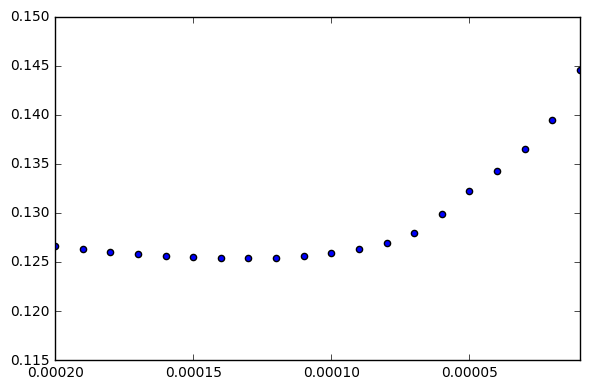

Plot zeigen ? (y/n)


In [43]:
from sklearn.linear_model import LassoCV 
#To try out to find the best alpha 
for x in (np.linspace(2e-4,1e-5,20)):
    print(x)
    model_lasso = LassoCV(n_jobs=-1, positive=True, alphas=[x],normalize=True)
    plt.scatter(x,rmse_cv(model_lasso).mean())
#   plt.plot(x,rmse_cv(model_lasso).mean())
plt.xlim(2e-4,1e-5)
plt.tight_layout()
plt.show()

model_lasso = LassoCV(n_jobs=-1, positive=True, alphas=[0.00012],normalize=True)
model_lasso.fit(np.log1p(X_train),np.log1p(y_train))
indices = np.argsort(model_lasso.coef_)
mask = model_lasso.coef_ != 0
coef = pd.Series(model_lasso.coef_[mask], index=X_train.columns[mask])
X_new = X_train[coef.index]
#print('Selected Fature',coef.sort_values())
x=input("Plot zeigen ? (y/n)")
if x == 'y':
    matplotlib.rcParams['figure.figsize'] = (8.0, 15.0)
    coef.sort_values().plot(kind = "barh")
    plt.title("Coefficients in the Lasso Model")
    plt.grid()
    plt.show()

32855.82108511227


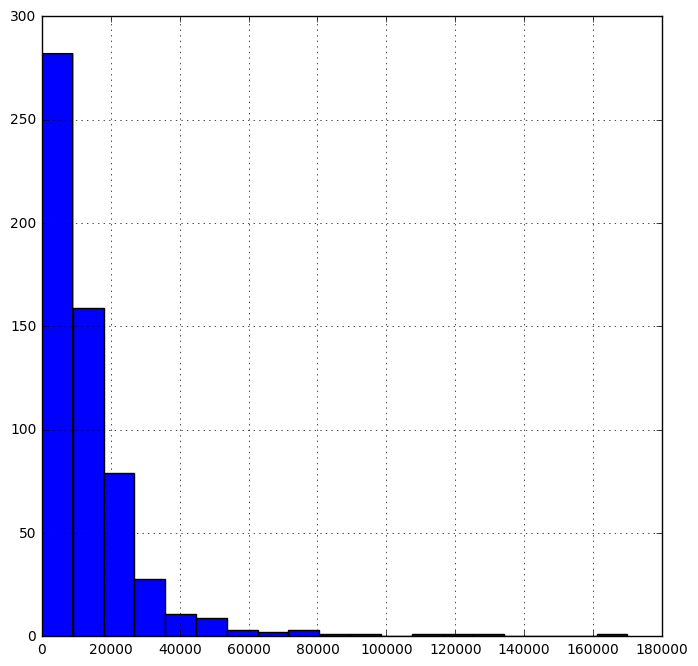

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test2, y_train2, y_test = train_test_split(X_new, y_train, test_size=0.4, random_state=0)

clf = LassoCV(n_jobs=-1, positive=True, alphas=[0.00012],normalize=True)
clf.fit(np.log1p(X_train),np.log1p(y_train2))
X = X_test2[coef.index]
predicted = np.expm1(clf.predict(np.log1p(X)))
plt.figure(figsize=(8,8))
#plt.scatter(predicted, y_test)
#plt.xlim(0,8e5)
#plt.ylim(0,8e5)
print(np.std(predicted-y_test))
plt.grid()
plt.hist(np.abs(predicted-y_test), np.linspace(0,1.7e5,20))
plt.show()

(1459,)


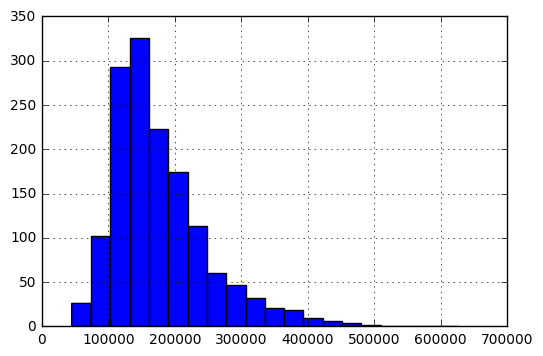

In [44]:
clf = LassoCV(n_jobs=-1, positive=True, alphas=[0.00012],normalize=True)
clf.fit(np.log1p(X_new),np.log1p(y_train))
X = X_test[coef.index]
predicted = np.expm1(clf.predict(np.log1p(X)))
print(predicted.shape)
plt.grid()
plt.hist(predicted,20)
plt.show()

import csv
with open('sample_submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'SalePrice']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for x in range(len(predicted)):
        writer.writerow({'Id': 1461+x, 'SalePrice': np.abs(predicted[x])})

In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor
clf.fit(np.log1p(X),np.log1p(y_train))
X = X_test[coef.index]
predicted = np.expm1(clf.predict(np.log1p(X)))
print(predicted.shape)
plt.grid()
plt.hist(predicted,20)
plt.show()

import csv
with open('sample_submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'SalePrice']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for x in range(len(predicted)):
        writer.writerow({'Id': 1461+x, 'SalePrice': np.abs(predicted[x])})